In [0]:

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("SalesForecastingSES") \
    .getOrCreate()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
data_path = "dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/sf_SESs.csv"
sales_data_spark = spark.read.csv(data_path, header=True, inferSchema=True)

In [0]:
sales_data = sales_data_spark.toPandas()

In [0]:
sales_data['LastSaleDate'] = pd.to_datetime(sales_data['LastSaleDate'])
sales_data.set_index('LastSaleDate', inplace=True)
monthly_sales = sales_data['Sales'].resample('M').sum()

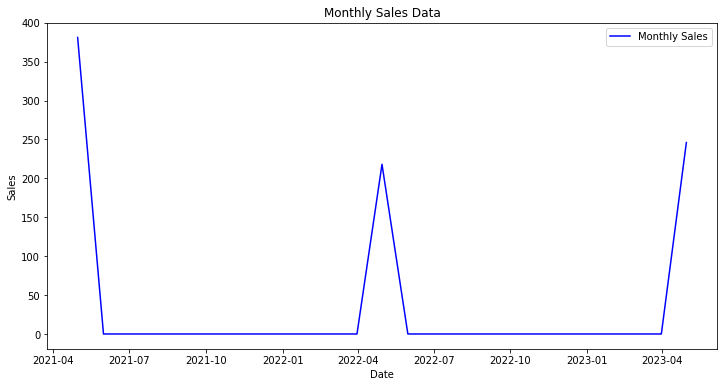

In [0]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Monthly Sales', color='blue')
plt.title('Monthly Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [0]:
ses_model = sm.tsa.SimpleExpSmoothing(monthly_sales)
ses_fit = ses_model.fit(smoothing_level=0.2, optimized=True)  # You can adjust the smoothing level

In [0]:
predictions = ses_fit.forecast(steps=12)
predicted_sales = pd.DataFrame(predictions, index=pd.date_range(start=monthly_sales.index[-1] + pd.DateOffset(1), periods=12, freq='M'), columns=['Predicted Sales'])

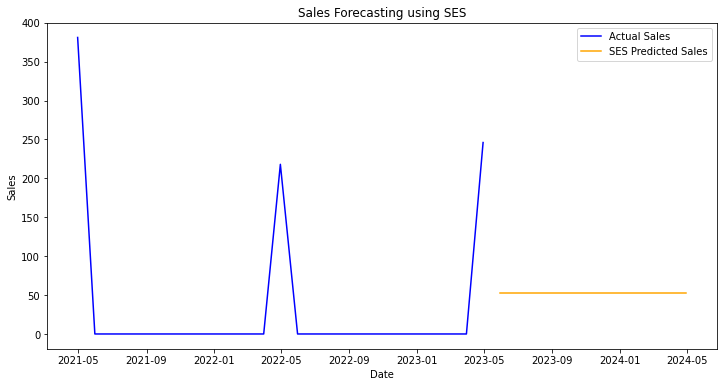

In [0]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Actual Sales', color='blue')
plt.plot(predicted_sales, label='SES Predicted Sales', color='orange')
plt.title('Sales Forecasting using SES')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [0]:
train_size = int(len(monthly_sales) * 0.8)
train, test = monthly_sales[:train_size], monthly_sales[train_size:]
ses_model = sm.tsa.SimpleExpSmoothing(train)
ses_fit = ses_model.fit(smoothing_level=0.2, optimized=True)
test_predictions = ses_fit.forecast(steps=len(test))

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(test, test_predictions))
mae = mean_absolute_error(test, test_predictions)
r_squared = r2_score(test, test_predictions)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared: {r_squared}')

Root Mean Squared Error (RMSE): 105.49826151897233
Mean Absolute Error (MAE): 55.89377941775791
R-squared: -0.14947732660840507


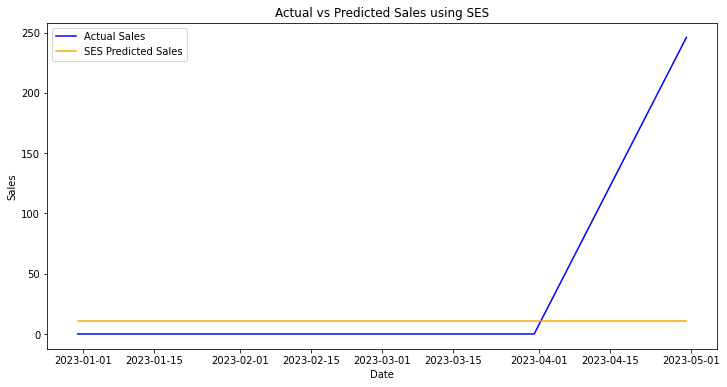

In [0]:
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual Sales', color='blue')
plt.plot(test.index, test_predictions, label='SES Predicted Sales', color='orange')
plt.title('Actual vs Predicted Sales using SES')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()